In [2]:
import sys
import os
sys.path.append('..')

import matplotlib.pyplot as plt
import xarray as xr
import pickle
import numpy as np

In [6]:
data_home = "/Users/emiliolr/Google Drive/My Drive/GTC"
rapid_depth = xr.open_dataset(os.path.join(data_home, 'rapid_26N', 'moc_vertical.nc'))

rapid_depth

<xarray.Dataset>
Dimensions:              (time: 13057, depth: 307)
Coordinates:
  * time                 (time) datetime64[ns] 2004-04-02 ... 2022-02-15
  * depth                (depth) float64 0.0 19.87 39.74 ... 5.976e+03 5.995e+03
Data variables:
    stream_function_mar  (depth, time) float64 ...
Attributes:
    Title:                         RAPID streamfunction
    Institution:                   National Oceanography Centre,UK
    Website:                       http://www.rapid.ac.uk/rapidmoc
    Acknowledgement:               The RAPID 26N AMOC monitoring project is f...
    Created_by:                    Ben Moat
    Creation_date:                 08-Sep-2023
    Principle_investigator:        Ben Moat
    Principle_investigator_email:  ben.moat@noc.ac.uk
    DOI:                           doi: 10.5285/04c79ece-3186-349a-e063-6c86a...

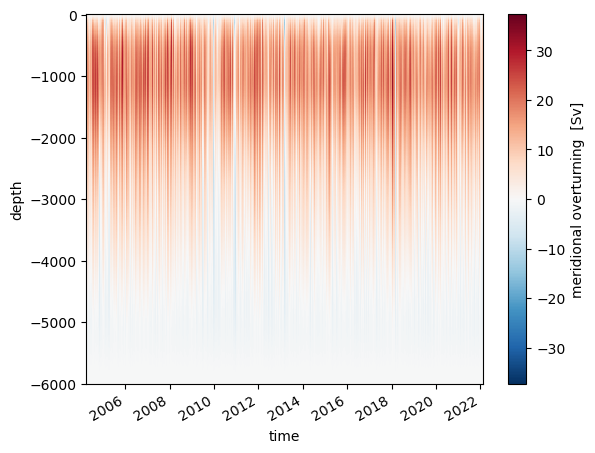

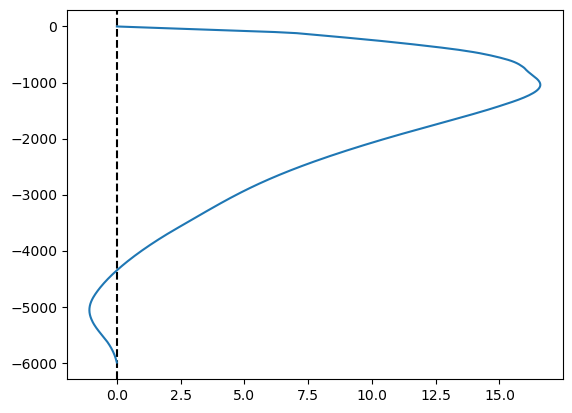

In [16]:
rapid_flipped = rapid_depth.stream_function_mar.assign_coords({'depth' : -1 * rapid_depth.depth})

rapid_flipped.plot()
plt.show()

plt.axvline(0, color = 'black', linestyle = '--')
plt.plot(rapid_flipped.mean('time'), rapid_flipped.depth)
plt.show()

In [17]:
# This temp and salinity data may not be useful for calculating potential density since it's
#   aggregated over longitudes...
rapid_temp_sal = xr.open_dataset(os.path.join(data_home, 'rapid_26N', 'ts_gridded.nc'))
rapid_temp_sal

<xarray.Dataset>
Dimensions:          (time: 13057, depth: 242)
Coordinates:
  * time             (time) datetime64[ns] 2004-04-02 ... 2022-02-15
Dimensions without coordinates: depth
Data variables: (12/19)
    pressure         (depth) float64 ...
    TG_west          (depth, time) float64 ...
    SG_west          (depth, time) float64 ...
    TG_wb3           (depth, time) float64 ...
    SG_wb3           (depth, time) float64 ...
    TG_east          (depth, time) float64 ...
    ...               ...
    TG_east_flag     (depth, time) float64 ...
    SG_east_flag     (depth, time) float64 ...
    TG_marwest_flag  (depth, time) float64 ...
    SG_marwest_flag  (depth, time) float64 ...
    TG_mareast_flag  (depth, time) float64 ...
    SG_mareast_flag  (depth, time) float64 ...
Attributes:
    Title:                         RAPID streamfunction
    Institution:                   National Oceanography Centre,UK
    Website:                       http://www.rapid.ac.uk/rapidmoc
    Acknowledgement:               The RAPID 26N AMOC monitoring project is f...
    Created_by:                    Ben Moat
    Creation_date:                 08-Sep-2023
    Principle_investigator:        Ben Moat
    Principle_investigator_email:  ben.moat@noc.ac.uk
    DOI:                           doi: 10.5285/04c79ece-3186-349a-e063-6c86a...